# Chapter 2 - Categorization of Text by summary

In this chapter, we will run a first categorization of the HP fanfiction English dataset based on the tropes found in the summary of each story. 

To identify the tropes, we will use the technique of Bag of Words and N-grams, to identify words which are the most important.

The goal is to be able to identify common tropes from the HP fanfiction world like '8th year', 'Mariage Law', 'Marauders', etc. The aim is to complete the current categorization done by the author with more hp-specific thematics.

A lot of the code is inspired from *Blueprints for Text Analytics using Python*, Jens Albrecht, Sidharth Ramachandran, Christian Winkler, O'Reilly, 2020, which can be found here : https://github.com/blueprints-for-text-analytics-python/blueprints-text

# Table of Content

- Settings
- Text Pre-Processing
- Word Frequency Analysis

# Settings

## Python settings & Importing the libraries 
Import the basic librairies : numpy, pandas, matplotlib, spacy, etc. Define the default settings for pandas and matplotlib

In [8]:
BASE_DIR = ".."
%run "$BASE_DIR/settings.py"

## Importing the Dataset
We will work with the English subset of the HP fanfiction dataset

In [18]:
pd.options.display.max_colwidth = 180 ###
#file = "$BASE_DIR/data/English-presentation-dataset/hpclean_engl.csv.gz"
file = f"{BASE_DIR}/data/English-presentation-dataset/hpclean_engl.csv.gz" #location of the file
df = pd.read_csv(file, index_col = 0)
df.sample(5, random_state=53)

,Chapters,Favs,Follows,Published,Reviews,Updated,Words,author,characters,genre,language,rating,story_link,synopsis,title,published_mmyy,pairing
587150,1,1.00,3.00,2/3/2006,1.00,NaN,622,reviews,"Hermione G., Ron W.",NaN,English,T,https://www.fanfiction.net/s/2783366/1/The-Sevenths-of-Year-Seven,Ron and Hermione. Intermittent moments on the Horcrux search.,The Sevenths of Year Seven,2-2006,"Hermione G., Ron W."
20320,96,61.00,48.00,12/30/2018,48.00,4/9/2019,346390,girlfromkerteh,"Sirius B., Remus L., James P., Peter P.",Angst/Romance,English,M,https://www.fanfiction.net/s/13162705/1/No-Such-Thing-As-Normal,"Forming the Marauders was the best thing that happened to all four of them, they lived for the camaraderie. But friendship doesn't come without a few misunderstandings, secrets...",No Such Thing As Normal,12-2018,NaN
582614,1,NaN,NaN,3/6/2006,2.00,NaN,182,reviews,"Remus L., Sirius B.",NaN,English,K,https://www.fanfiction.net/s/2832277/1/Long-Black-Hair,A poem about Remus mourning Sirius after the fall through the veil.,Long Black Hair,3-2006,"Remus L., Sirius B."
199722,3,71.00,71.00,5/27/2013,14.00,12/6/2014,4264,Unspeakable Phoenix,"Harry P., Daphne G.",Adventure/Romance,English,M,https://www.fanfiction.net/s/9332263/1/Hidden-Secrets,"Summary: Harry is a mega powerful wizard, still good though with Slytherin friends. Harry gets resorted in fourth year and is secretly dating Daphne until his fourteenth birthd...",Hidden Secrets,5-2013,NaN
48268,1,30.00,31.00,11/17/2017,4.00,3/5/2018,1906,reviews,"[Tom R. Jr., OC] Severus S.",Romance/Adventure,English,T,https://www.fanfiction.net/s/12728541/1/His-Most-Faithful,"Instead of a child to defeat the Dark Lord, what if Fate send a child to help him win the war? Divini Le Fay made her journey to Hogwarts and later becomes the Dark Lord's most...",His Most Faithful,11-2017,"Tom R. Jr., OC"


## Data Preparation
### Column names standardization

In [20]:
# Changing the column names to simplify the analysis : removing capital letters and labeling "summary" as "text"
df.columns = ['chapters', 'favs', 'follows', 'published', 'reviews', 'updated',
       'words', 'author', 'characters', 'genre', 'language', 'rating',
       'story_link', 'text', 'title', 'published_mmyy', 'pairing']

### Checking Missing Data

In [23]:
df.isna().sum()

chapters               0
favs               56502
follows           108186
published              0
reviews            40723
updated           322008
words                  0
author                 0
characters         51657
genre              48073
language               0
rating                 0
story_link             0
text                  10
title                 14
published_mmyy         0
pairing           201460
dtype: int64

We will remove text with no summary nor title, since they will get problematic during our analysis.

In [24]:
df['text'].dropna(inplace = True)
df['title'].dropna(inplace = True)

## Checking Types

In [34]:
df.dtypes

chapters            int64
favs              float64
follows           float64
published          object
reviews           float64
updated            object
words               int64
author             object
characters         object
genre              object
language           object
rating             object
story_link         object
text               object
title              object
published_mmyy     object
pairing            object
dtype: object

In [37]:
df[['text', 'title']] = df[['text', 'title']].astype('str')

# Text Preprocessing

## Tokenization with regular expression

In [31]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

## Treating Stop Words

In [25]:
import nltk
# not in book: make sure stop words are available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pauli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [27]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

Select the type of stop words to include or not in the list : this action depends heavily on the type of dataset. At a first analysis, we will not add any stop words but we may add this information later on.

In [29]:
include_stopwords = {''}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

## Processing a Pipeline with one Line of Code

In [32]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [38]:
df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)

100%|██████████| 506057/506057 [00:24<00:00, 20276.24it/s]


# Analysing word Frequency

In [39]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [40]:
freq_df = count_words(df)
freq_df.head(5)

100%|██████████| 506057/506057 [00:03<00:00, 164682.35it/s]


,freq
token,
harry,183954
hermione,103467
one,81663
draco,77793
hogwarts,63975


In [41]:
freq_df.head(10)

,freq
token,
harry,183954
hermione,103467
one,81663
draco,77793
hogwarts,63975
potter,60048
year,53544
story,50236
love,49870


## Frequency Diagram

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

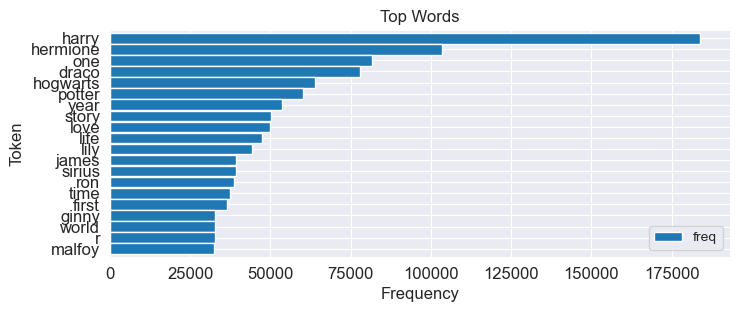

In [43]:
ax = freq_df.head(20).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')